# Analyzing NHL Team Locations

## 1 Import Libraries

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd
import re

## 2 Load and Clean Data

In [2]:
def decode_coordinates(coords):
    new_coords = []
    for coord in coords.split():
        split_coord = re.split(r'°|\'|\"|′|″', coord)
        if len(split_coord) == 4:
            degrees, minutes, seconds, direction = split_coord
            new_coords.append(degrees_to_decimal(int(degrees), int(minutes), float(seconds), direction))
        elif len(split_coord) == 2:
            degrees, direction = split_coord
            new_coords.append(degrees_to_decimal(float(degrees), 0, 0, direction))
    return new_coords

def degrees_to_decimal(degrees, minutes, seconds, direction):
    result = degrees + minutes/60 + seconds/3600
    return result if direction in ['N', 'E'] else -result

In [3]:
arenas = pd.read_excel('arenas.xlsx')
arenas['division'] = pd.Categorical(arenas['division'])
arenas[['y', 'x']] = pd.DataFrame(arenas['coordinates'].apply(decode_coordinates).tolist(), index=arenas.index)

## 3 Plot Team Locations by Division

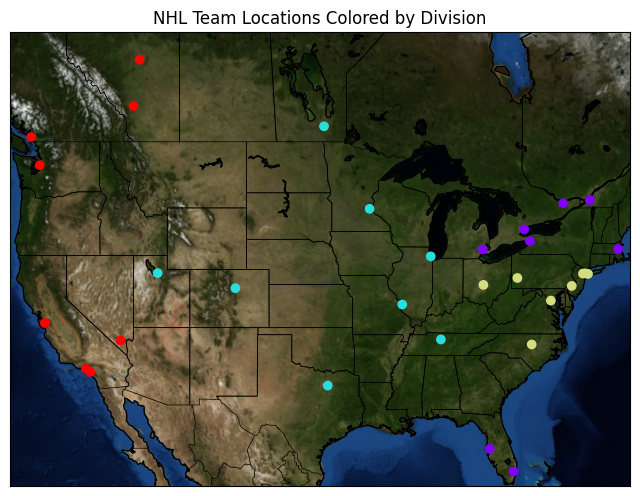

In [4]:
plt.gcf().set_size_inches(8, 6.5)
m = Basemap(projection='merc', llcrnrlat=25, urcrnrlat=55, llcrnrlon=-125, urcrnrlon=-70, resolution='l')
m.bluemarble()
m.drawcoastlines()
m.drawcountries()
m.drawstates()
x, y = m(arenas['x'], arenas['y'])
plt.scatter(x, y, c=arenas['division'].cat.codes, cmap='rainbow', zorder=10)
plt.title('NHL Team Locations Colored by Division')
plt.show()

These don't make much sense geographically, especially in the East. Let's see if we can improve the divisions.

## 4 Cluster for Better Alignment

This code to ensure even clusters came from [here](https://stackoverflow.com/questions/5452576/k-means-algorithm-variation-with-equal-cluster-size).

In [5]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import numpy as np

def get_even_clusters(X, cluster_size):
    n_clusters = int(np.ceil(len(X)/cluster_size))
    kmeans = KMeans(n_clusters)
    kmeans.fit(X)
    centers = kmeans.cluster_centers_
    centers = centers.reshape(-1, 1, X.shape[-1]).repeat(cluster_size, 1).reshape(-1, X.shape[-1])
    distance_matrix = cdist(X, centers)
    clusters = linear_sum_assignment(distance_matrix)[1]//cluster_size
    return clusters

We probably want to keep the Eastern and Western conferences, so let's optimize those.

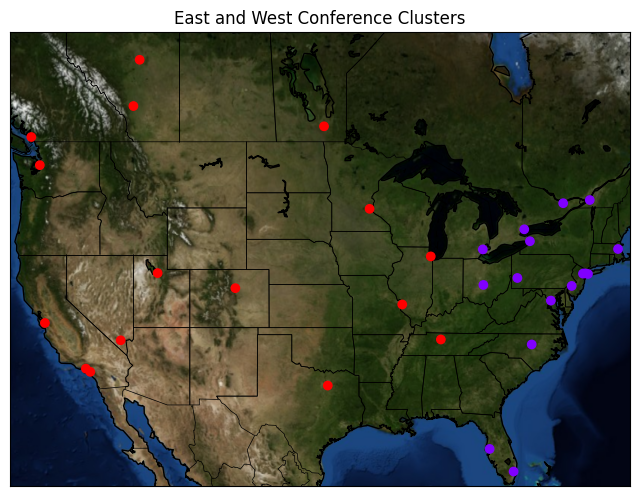

In [6]:
plt.gcf().set_size_inches(8, 6.5)
m = Basemap(projection='merc', llcrnrlat=25, urcrnrlat=55, llcrnrlon=-125, urcrnrlon=-70, resolution='l')
m.bluemarble()
m.drawcoastlines()
m.drawcountries()
m.drawstates()
x, y = m(arenas['x'], arenas['y'])
plt.scatter(x, y, c=get_even_clusters(arenas[['x','y']], 16), cmap='rainbow', zorder=10)
plt.title('East and West Conference Clusters')
plt.show()

It seems the current conferences are ideal. Let's cluster two divisions within each conference.

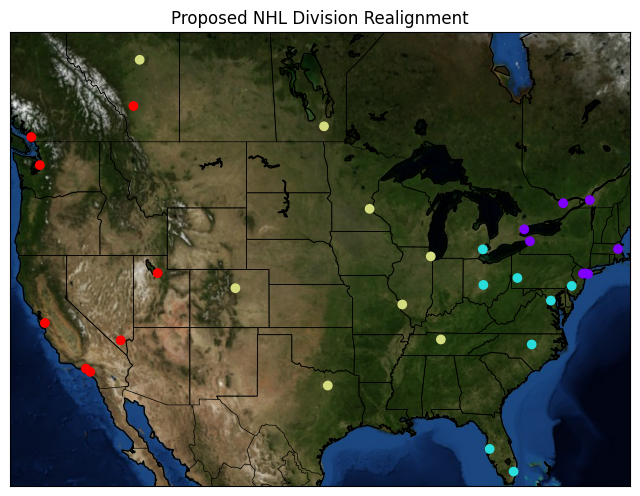

In [7]:
arenas['new_division'] = arenas['division'].cat.codes
arenas['new_division'] = pd.Categorical(arenas['new_division'])
arenas.loc[arenas['conference'] == 'Eastern', 'new_division'] = get_even_clusters(arenas.loc[arenas['conference'] == 'Eastern', ['x','y']], 8)
arenas.loc[arenas['conference'] == 'Western', 'new_division'] = get_even_clusters(arenas.loc[arenas['conference'] == 'Western', ['x','y']], 8) + 2

plt.gcf().set_size_inches(8, 6.5)
m = Basemap(projection='merc', llcrnrlat=25, urcrnrlat=55, llcrnrlon=-125, urcrnrlon=-70, resolution='l')
m.bluemarble()
m.drawcoastlines()
m.drawcountries()
m.drawstates()
x, y = m(arenas['x'], arenas['y'])
plt.scatter(x, y, c=arenas['new_division'].cat.codes, cmap='rainbow', zorder=10)
plt.title('Proposed NHL Division Realignment')
plt.show()

There are two different ways to cluster the East:
1. New England, Appalachia
   1. NE: <span style='color:cyan'>Bruins, Canadiens, Senators, Maple Leafs, Sabres</span>, <span style='color:magenta'>Devils, Rangers, Islanders</span>
   2. AP: <span style='color:red'>Panthers, Lightning, Hurricanes, Capitals, Flyers</span>, <span style='color:yellow'>Penguins, Blue Jackets, Red Wings</span>
2. Great Lakes, Atlantic Coast
   1. GL: <span style='color:cyan'>Bruins, Canadiens, Senators, Maple Leafs, Sabres</span>, <span style='color:yellow'>Penguins, Blue Jackets, Red Wings</span>
   2. AC: <span style='color:red'>Panthers, Lightning, Hurricanes, Capitals, Flyers</span>, <span style='color:magenta'>Devils, Rangers, Islanders</span>

The algorithm seems to only ever cluster the West in one way, but I think two are viable:
1. Same old, same old
   1. Central: <span style='color:cyan'>Jets, Wild, Blackhawks, Predators, Blues, Stars, Avalanche</span>, <span style='color:magenta'>NHL Team</span>
   2. Pacific: <span style='color:red'>Golden Knights, Ducks, Kings, Sharks, Kraken, Canucks, Flames</span>, <span style='color:yellow'>Oilers</span>
2. Allegedly optimal
   1. Central: <span style='color:cyan'>Jets, Wild, Blackhawks, Predators, Blues, Stars, Avalanche</span>, <span style='color:yellow'>Oilers</span>
   2. Pacific: <span style='color:red'>Golden Knights, Ducks, Kings, Sharks, Kraken, Canucks, Flames</span>, <span style='color:magenta'>NHL Team</span>

I like the current divisions in the West and the New England & Appalachia divisions in the East, since they preserve the most rivalries.